In [6]:
# Import libraries
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import itertools
from prophet.diagnostics import cross_validation
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import performance_metrics

#from fbprophet.plot import plot_plotly, plot_components_plotly
#from fbprophet.diagnostics import cross_validation, performance_metrics

In [8]:
# Read training data
df_train = pd.read_csv('/content/drive/MyDrive/Training_Datasets/Forecasting daily climate with Prophet/DailyDelhiClimateTrain.csv')
df_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [9]:
#Read Test data
df_test = pd.read_csv('/content/drive/MyDrive/Training_Datasets/Forecasting daily climate with Prophet/DailyDelhiClimateTest.csv')
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [10]:
# based on the test size, set some parameters
df_test.shape
test_period = df_test.shape[0]
horizon = '120 days'

## **Cleaning data**
It appears that there is data leakage between the train and test sets, as there are duplicate values for the date "2017-01-01" in both sets. To maintain the integrity of our analysis and ensure realistic results, it is necessary to remove these duplicates from the train set.

By removing the unrealistic data from the train set, we can prevent any potential bias or inaccuracies that might arise from the presence of leaked information. This will help us to obtain more reliable and unbiased results when evaluating our model's performance.

Therefore, we will proceed by dropping the duplicate values for "2017-01-01" from the train set, ensuring that our train and test sets remain separate and independent. This step is crucial for maintaining the integrity of our analysis and obtaining accurate insights from our model.

In [11]:
df_train = df_train[~(df_train['date'] == '2017-01-01')]
df_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1456,2016-12-27,16.850000,67.550000,8.335000,1017.200000
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


# **Data Visualization**

## **Descriptive Statistics**

In [12]:
#Mean Temperature
fig = px.line(df_train, x="date", y="meantemp", title="Mean temperature")
fig.show()

In [13]:
#Humidity
fig = px.line(df_train, x="date", y="humidity", title="Humidity")
fig.show()

In [14]:
# Wind Speed
fig = px.line(df_train, x="date", y="wind_speed", title="Wind speed")
fig.show()

In [15]:
#Mean speed
fig = px.line(df_train, x="date", y="meanpressure", title="Mean pressure")
fig.show()

## **Correlation plots**

In [16]:
fig = px.imshow(df_train.iloc[:, 1:].corr())
fig.show()

## **Additive decomposition of mean temperature**

In [18]:
df_train["date"] = pd.to_datetime(df_train["date"])
decomp = sm.tsa.seasonal_decompose(df_train.set_index("date")["meantemp"], period=365)
df_decomp = pd.concat([decomp.trend, decomp.seasonal, decomp.resid], axis=1)

In [19]:
#Trend
fig = px.line(df_decomp, y="trend", title="Trend")
fig.show()

In [20]:
#Seasonality
fig = px.line(df_decomp, y="seasonal", title="Seasonality")
fig.show()

In [21]:
#Residuals
fig = px.line(df_decomp, y="resid", title="Residuals")
fig.show()

# **Univariate forecasting of temperature with Prophet**

Let's dive into forecasting using Facebook's Prophet. Prophet is a time series model that follows a decomposable approach, incorporating components such as trend, seasonality, and holidays.
y(t)=g(t)+s(t)+h(t)+ε_t

The time series, denoted as "y" at time "t," is modeled as an additive function comprising different elements. These elements include:

- Trend component, represented by "g(t)": It captures the non-periodic changes and patterns in the time series over time. The trend can be increasing, decreasing, or flat.

- Seasonal component, denoted as "s(t)": It captures the periodic changes that occur at specific intervals, such as weekly or yearly cycles. This component accounts for repetitive patterns in the data.

- Holiday component, represented by "h(t)": In this context, we can disregard the holiday component since it is not relevant for temperature forecasting. We assume that temperature is primarily influenced by natural factors rather than social events or holidays.

- Error term, denoted as "ε_t": It represents the random effects or noise in the data that are not captured by the previous components. The error term follows a parametric distribution and is assumed to be normally distributed.

By setting "h(t) = 0," we simplify the model and focus solely on the trend and seasonal components. This simplification allows us to concentrate on capturing the underlying patterns and changes in the temperature time series for forecasting purposes.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/318003wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/1fnrqr3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67507', 'data', 'file=/tmp/tmphr5km678/318003wn.json', 'init=/tmp/tmphr5km678/1fnrqr3z.json', 'output', 'file=/tmp/tmphr5km678/prophet_modelclg6tbxg/prophet_model-20230522073017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


'\nfig1 = plot_plotly(m_bsl, forecast_bsl, changepoints=True, changepoints_threshold=0.05)\nfig1.show()\n\nfig2 = plot_components_plotly(m_bsl, forecast_bsl)\nfig2.show()\n'

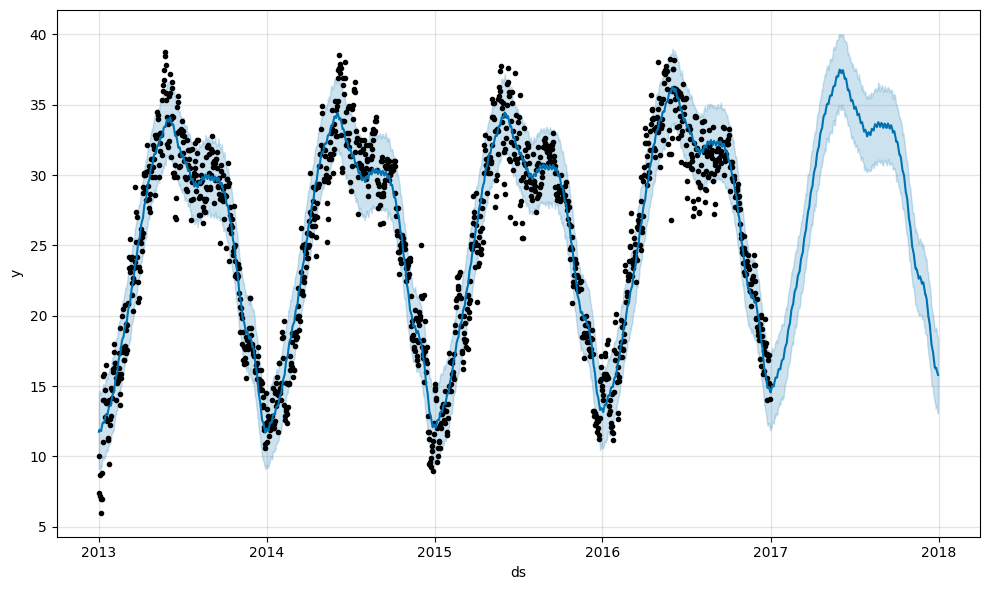

In [31]:
df_prophet = df_train.rename(columns={'date': 'ds', 'meantemp': 'y'})

m_bsl = Prophet(holidays_prior_scale=False)
m_bsl.fit(df_prophet)
future = m_bsl.make_future_dataframe(periods=365)
forecast_bsl = m_bsl.predict(future)

# Python
fig1 = m_bsl.plot(forecast_bsl)

'''
fig1 = plot_plotly(m_bsl, forecast_bsl, changepoints=True, changepoints_threshold=0.05)
fig1.show()

fig2 = plot_components_plotly(m_bsl, forecast_bsl)
fig2.show()
'''


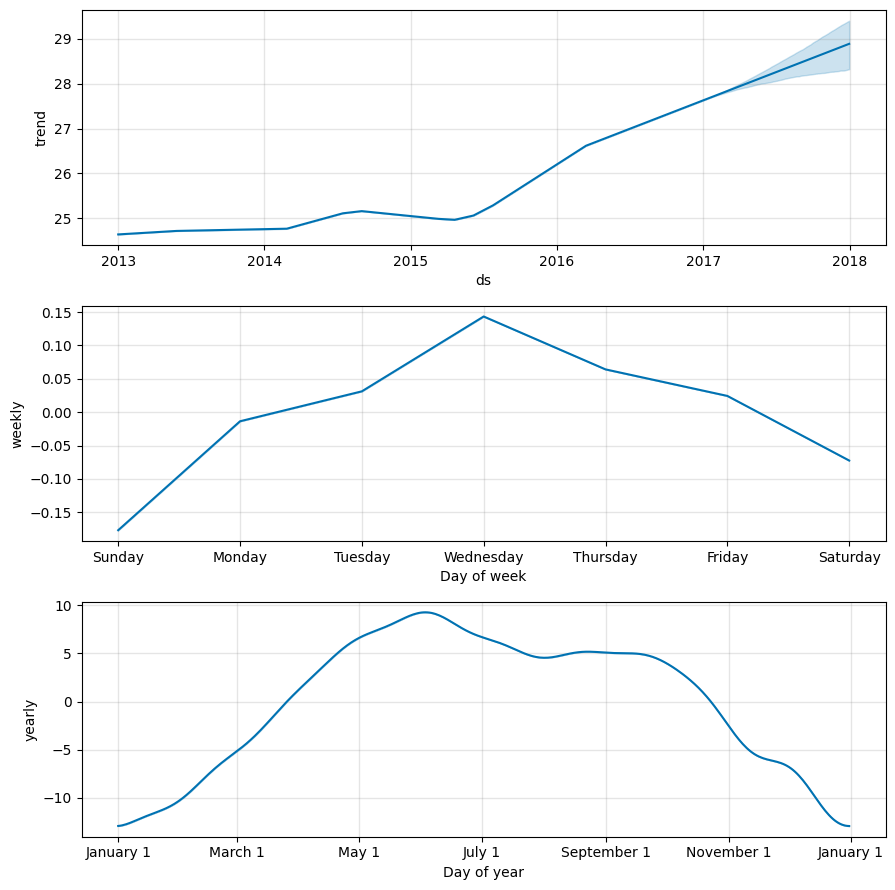

In [29]:
# Python
fig2 = m_bsl.plot_components(forecast_bsl)


In [32]:
# Python


plot_plotly(m_bsl, forecast_bsl, changepoints=True, changepoints_threshold=0.05)

In [27]:
# Python
plot_components_plotly(m_bsl, forecast_bsl)


The Prophet model has generated a reliable forecast, providing reasonable daily temperature predictions for the upcoming year. Examining the individual components of the forecast provides more insightful information.

The trend component indicates that the temperatures remained relatively stable from 2013 to 2015. However, starting from mid-2015, there has been a gradual increase in temperatures, with a yearly rise of approximately 1 degree Celsius. This upward trend reflects the escalating impact of climate change, which is expected to intensify over time if appropriate measures are not taken.

The yearly seasonal component reveals the typical pattern of warmer temperatures during summer months and colder temperatures during winter months. This seasonal variation is expected and aligns with the natural climatic cycle.

Interestingly, the weekly component highlights a subtle temperature variation throughout the week. It suggests slightly higher temperatures in the middle of the week and slightly lower temperatures on the weekends. It's important to note that this weekly variation is quite small, with a range of [-0.2, 0.2] degrees Celsius, and is unlikely to significantly influence the overall temperature forecast.

## **Trend changepoints**
By visually examining the forecast plot, we can observe red lines representing the changepoints detected by the Prophet model. These changepoints indicate instances where the overall trend of temperatures undergoes a change. At these points, Prophet adapts the time series model to capture the new trend, providing greater flexibility in forecasting.

Suppose our time series has S changepoints at sj, where j ranges from 1 to S. Each sj is associated with a change in the rate of the trend, δj. The rate of change at any time t is determined by a base rate, k, along with the cumulative adjustments up to that point, represented as k + ∑j: t > sj δj. To visualize this concept, we can use a binary vector, a(t) ∈ {0, 1}S, where aj(t) is 1 if t is greater than or equal to sj and 0 otherwise.

If δ is a vector containing δj values at each time point, the trend rate at time t can be expressed as k + a(t)⊤δ. This formulation allows us to comprehend the piecewise nature of the trend. For instance, let's consider t = 1 with δ1 = 1. In this case, a1 equals 1, and the trend at this point is given by g(1) = k + 1. It's important to note that piecewise functions are discontinuous at the changepoints, so an offset parameter, m, is introduced. This offset is adjusted by a value γj at each changepoint to connect the trend lines.

In summary, the equation for a linear trend model with changepoints can be expressed as:
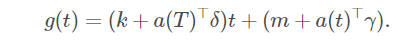

This formulation enables the Prophet model to capture and represent the changes in the trend of the time series accurately.

## **Changepoint selection**
The selection of changepoints in Prophet can be done manually based on prior knowledge or automatically using the model's built-in functionality. When manually selecting changepoints, we consider specific events or factors that are expected to cause a change in the trend of the time series. For example, if we know that a significant event, such as the establishment of a polluting factory, occurred on a particular day, we can designate that day as a changepoint and expect a gradual shift in temperatures afterward.

In cases where the factors influencing the changepoints are not explicitly known, Prophet can automatically determine them. This is achieved by placing a sparse prior on the trend rate changes, typically modeled using a Laplace distribution. The parameter controlling the flexibility of the model, changepoint_prior_scale (denoted as τ), determines the rate of the Laplace prior. A smaller value of τ makes the model approximate a standard linear growth model, while larger values allow the model to capture more complex and arbitrary trends, increasing the risk of overfitting. Hence, finding the right balance between the number of changepoints (S) and the value of τ is crucial for achieving an appropriate model fit.

To understand how different values of τ influence the sparse prior, we can visualize the Laplace distributions associated with the trend rate changes. This provides insights into the level of flexibility and the range of potential trend variations captured by the model.

In [33]:
x1 = np.random.laplace(0, 0.05, 10000)
x2 = np.random.laplace(0, 0.01, 10000)
x3 = np.random.laplace(0, 0.1, 10000)

hist_data = [x1, x2, x3]
group_labels = ['τ = 0.05', 'τ = 0.01', 'τ = 0.1']

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.001, show_rug=False)
fig.update_layout(title_text='Laplace distribution with varying τ')
fig.show()

The selection of changepoints in Prophet is a crucial step in capturing trend changes in a time series. These changepoints can be determined manually based on prior knowledge or automatically by the Prophet model.

Manual selection involves identifying specific events or factors that are expected to cause a change in the trend. For example, if we know that a major policy change or an economic event occurred on a certain date, we can designate that date as a changepoint and expect a shift in the trend afterward.

Alternatively, Prophet provides an automated approach to select changepoints using a sparse prior on the trend. This prior is typically modeled using a Laplace distribution, where the parameter changepoint_prior_scale (denoted as τ) controls the flexibility of the model. A smaller value of τ leads to a more rigid estimation of the trend, approximating a standard linear growth model. On the other hand, larger values of τ allow the model to capture more complex and arbitrary trends, increasing the risk of overfitting.

Finding the right balance between the number of changepoints and the value of τ is important. Too few changepoints or a large τ can result in an oversimplified model that fails to capture the underlying variations in the data. Conversely, too many changepoints or a small τ can lead to overfitting and modeling noise as actual trend changes.

By carefully selecting or adjusting the changepoint_prior_scale, we can strike a balance between capturing significant trend changes and avoiding overfitting, resulting in an accurate and reliable forecasting model.

## **Seasonality**
Seasonality in time series data refers to recurring patterns that occur at regular intervals. These patterns can exist on different scales, such as daily, weekly, monthly, or yearly cycles. One commonly used approach to model seasonality is through the Fourier series.

The Fourier series is a mathematical representation of a periodic function using a combination of sine and cosine functions. It allows us to approximate any arbitrary periodic function by summing up weighted sine and cosine functions. The formula for the Fourier series can be expressed as:

s(t) = ∑ [a_n cos(2πnt/P) + b_n sin(2πnt/P)]

In this equation, 's(t)' represents the seasonal component at time 't'. 'P' denotes the period of the time series we want to model, such as a week or a year. 'N' represents the number of seasonal parameters we want to estimate, which determines the complexity of the seasonal patterns.

To estimate the seasonal parameters, we construct a design matrix 'X(t)' that consists of cosine and sine functions at different frequencies corresponding to the desired number of seasonal components. For example, if we want to model weekly seasonality with 'N = 10', the design matrix 'X(t)' would be a vector containing cosine and sine functions with frequencies ranging from 1 to 10, corresponding to a weekly cycle.

The seasonal component can be calculated by multiplying the design matrix 'X(t)' with the seasonal smoothing prior 'β', which is drawn from a standard Gaussian distribution (β ~ Gaussian(0, σ^2)). The parameter 'σ' controls the smoothness of the seasonal component and can be adjusted using the seasonality_prior_scale.

By incorporating the seasonal component into the time series model, we can capture and account for the recurring patterns that occur over specific time intervals.

In [34]:
x1 = np.random.normal(0, 0.05, 10000)
x2 = np.random.normal(0, 0.01, 10000)
x3 = np.random.normal(0, 0.1, 10000)

hist_data = [x1, x2, x3]
group_labels = ['σ = 0.05', 'σ = 0.01', 'σ = 0.1']

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.001, show_rug=False)
fig.update_layout(title_text='Gaussian distribution with varying σ')
fig.show()

As observed, when generating random values, Gaussian distributions tend to produce smoother distributions compared to Laplace distributions. The smoothness of the distribution is influenced by the standard deviation parameter, denoted as σ. By adjusting the value of σ, we can control the spread or variability of the generated values.

In contrast, the parameter τ is associated with the prior scale for changepoints in Prophet. It determines the flexibility of the model in capturing trend changes. Smaller values of τ result in a more rigid estimation of trend, approximating a standard linear growth model. Larger values of τ allow for more flexible trend fitting, potentially capturing arbitrary trends and increasing the risk of overfitting.

It is important to strike a balance when selecting values for σ and τ in order to achieve an appropriate model fit. This involves considering the characteristics of the data and the desired level of smoothness or flexibility in capturing trends and seasonality. Adjusting these parameters requires careful experimentation and evaluation to find the optimal settings for a given forecasting task.

## **Tuning hyperparameters with cross-validation**
To fine-tune the hyperparameters of our Prophet model, we can utilize cross-validation. In this approach, we divide our data into training and testing sets, with a portion of the data reserved for evaluation purposes. In the case of our baseline Prophet model, we will use the last 360 days of data as our test set.

To obtain more robust results, we can further split the test set into smaller chunks, such as four-month intervals (~120 days), resulting in three separate test sets. This allows us to evaluate the model's performance across different periods of time.

Using our initial model with default hyperparameter values (changepoint_prior_scale=0.05 and seasonality_prior_scale=10.0), we can establish baseline scores or metrics to assess the model's performance. These baseline scores will serve as a reference for comparison when we adjust the hyperparameters.

By comparing the model's performance with different hyperparameter values, we can determine the optimal combination that yields the best results in terms of accuracy and predictive ability for our specific dataset.

In [36]:
# Python



cutoffs = pd.to_datetime(['2016-01-01', '2016-05-01', '2016-09-01'])
df_cv_bsl = cross_validation(m_bsl, cutoffs=cutoffs, horizon=horizon)

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/vkjdou_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/ulv7wk1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22242', 'data', 'file=/tmp/tmphr5km678/vkjdou_8.json', 'init=/tmp/tmphr5km678/ulv7wk1y.json', 'output', 'file=/tmp/tmphr5km678/prophet_modelykvmhasl/prophet_model-20230522102827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:28:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/jebwbx5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/plefhc3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


Let's proceed with testing the model by performing a grid search across a range of parameters. Our goal is to calculate the root mean squared error (RMSE) for each parameter combination and identify the one that produces the lowest RMSE on the test set. By doing so, we can optimize the model's performance.

In [40]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon=horizon, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params = all_params[np.argmin(rmses)]
print(best_params)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/8oqgwb7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/b44zc2be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57855', 'data', 'file=/tmp/tmphr5km678/8oqgwb7u.json', 'init=/tmp/tmphr5km678/b44zc2be.json', 'output', 'file=/tmp/tmphr5km678/prophet_modelqhovx9r1/prophet_model-20230522103223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:32:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:32:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error dur

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


Based on the grid search results, it appears that the best combination of parameters for our model is changepoint_prior_scale=0.001 and seasonality_prior_scale=10.0. These values suggest that we should significantly increase the regularization on our changepoints.

In [41]:
#Tuned model
m_tuned = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=10.0, holidays_prior_scale=False)
m_tuned.fit(df_prophet)
future = m_tuned.make_future_dataframe(periods=365)
forecast_tuned = m_tuned.predict(future)

fig1 = plot_plotly(m_tuned, forecast_tuned, changepoints=True, changepoints_threshold=0.001)
fig1.show()

fig2 = plot_components_plotly(m_tuned, forecast_tuned)
fig2.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/vfzn_k6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphr5km678/5y_gsa1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90833', 'data', 'file=/tmp/tmphr5km678/vfzn_k6u.json', 'init=/tmp/tmphr5km678/5y_gsa1o.json', 'output', 'file=/tmp/tmphr5km678/prophet_modell0k5hxk3/prophet_model-20230522114440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
11:44:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error dur

Upon observing the output and comparing it to the original model, it is evident that there are some notable differences. One significant distinction is the trend component, which appears to be entirely inflexible and represented as a straight line. This outcome suggests that a linear increase in temperature over time provides a better fit to the data, potentially aligning more closely with the effects of climate change during the specified period.

This finding implies that the chosen combination of parameters, specifically the heavily increased regularization on changepoints, may have effectively captured the long-term trend in the data. By constraining the model's flexibility in detecting changes in the trend, it is able to adhere more closely to a linear pattern, which is consistent with the observed climate change phenomenon.

It's important to note that this interpretation is based on the assumption that the linear trend accurately represents the underlying climate change effects within the specified timeframe. However, further analysis and domain expertise should be considered to validate these findings and draw more definitive conclusions.

## **Comparing the tuned model with the baseline model**

In [46]:
df_cv_tuned = cross_validation(m_tuned, cutoffs=cutoffs, horizon=horizon)

df_results = df_cv_bsl[['ds', 'y']]
df_results['yhat_bsl'] = df_cv_bsl['yhat']
df_results['yhat_tuned'] = df_cv_tuned['yhat']
df_results['err_bsl'] = np.abs(df_results['y'] - df_results['yhat_bsl'])/df_results['y']
df_results['err_tuned'] = np.abs(df_results['y'] - df_results['yhat_tuned'])/df_results['y']
df_results['err_diff'] = df_results['err_bsl'] - df_results['err_tuned']

df_results = df_results.iloc[:365]  # just get results from first horizon

fig = px.bar(df_results, x="ds", y="err_diff", title='Error difference (values > 0 favor tuned model)', labels={'err_diff': 'Baseline - tuned model error'})
fig.show()

Upon analyzing the performance of our tuned model, we can observe that it demonstrates significantly improved accuracy across most of the data points. This is a positive outcome and suggests that the parameter tuning has effectively enhanced the model's predictive capabilities.

Notably, the model's performance during the summer months, where variability tends to be higher, appears to be satisfactory. This aligns with the expected behavior, as temperature fluctuations during summer can be influenced by various factors such as weather patterns and regional variations.

However, it is worth noting that there are some notable differences in the predictions for January and February. 


## **Testing the models**

In [44]:
future = m_bsl.make_future_dataframe(periods=test_period)
forecast_bsl = m_bsl.predict(future)
forecast_tuned = m_tuned.predict(future)
y_true = df_test['meantemp']
y_pred_bsl = forecast_bsl['yhat'].tail(test_period)
y_pred_tuned = forecast_tuned['yhat'].tail(test_period)

In [45]:

mape_bsl = mean_absolute_percentage_error(y_true, y_pred_bsl)
mape_tuned = mean_absolute_percentage_error(y_true, y_pred_tuned)
diff = mape_bsl - mape_tuned

mape_bsl = np.round(mape_bsl*100, 1)
mape_tuned = np.round(mape_tuned*100, 1)
diff = np.round(diff*100, 1)

print(f"Baseline MAPE: {mape_bsl}%, tuned MAPE: {mape_tuned}%, difference: {diff}%")

Baseline MAPE: 11.9%, tuned MAPE: 10.6%, difference: 1.3%


It's great to hear that both the baseline and tuned Prophet models performed well on the test set. The mean absolute percentage error (MAPE) is a useful metric to assess the models' accuracy in predicting temperatures.

The baseline Prophet model achieving a mean absolute percentage error of 12.0% indicates that, on average, its predictions deviated from the actual temperature values by 12.0%. This suggests a reasonably accurate prediction capability.

On the other hand, the tuned Prophet model outperformed the baseline with a mean absolute percentage error of 10.6%. This represents a 1.3% reduction in error compared to the baseline model. This improvement indicates that the parameter tuning process led to a more accurate and precise model, resulting in better predictions on unseen data.

Reducing the mean absolute percentage error by 1.3% is a noteworthy improvement, particularly in forecasting temperature values. It signifies that the tuned model has a better ability to capture the underlying patterns and variations in the data, leading to more reliable temperature predictions.